In [1]:
#Reset workspace*
%reset -f
# imports
import numpy as np
import pandas as pd 
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl

# this allows plots to appear directly in the notebook
%matplotlib inline 

demo = pd.io.parsers.read_table('/Users/davidpena/Desktop/PosgradoUB/Proyecto/BBVA/demographic_distribution000', sep='\t', names =['zipcode','date','category','age','gender', 'merchants', 'cards','numpayments', 'avgpayment', 'max', 'min', 'std'])
print demo.shape
demo.head()

(48538, 12)


,zipcode,date,category,age,gender,merchants,cards,numpayments,avgpayment,max,min,std
0,8001,2014-07-01,es_food,unknown,unknown,8,25,26,13.73,31.50,1.50,8.015002
1,8001,2014-07-24,es_transportation,unknown,unknown,12,59,60,16.12,92.00,1.25,17.882527
2,8001,2014-07-09,es_otherservices,unknown,unknown,12,64,64,43.42,275.00,4.10,52.466928
3,8001,2014-07-09,es_food,unknown,unknown,7,28,29,11.72,30.56,0.90,8.120161
4,8001,2014-07-25,es_barsandrestaurants,35-44,male,5,5,5,46.02,165.00,7.10,59.893586


In [2]:
bars= demo[demo.category=='es_barsandrestaurants']
print 'Our data frame now have the following size: ', bars.shape 
bars.head()

Our data frame now have the following size:  (9076, 12)


,zipcode,date,category,age,gender,merchants,cards,numpayments,avgpayment,max,min,std
4,8001,2014-07-25,es_barsandrestaurants,35-44,male,5,5,5,46.02,165.00,7.10,59.893586
5,8001,2014-07-02,es_barsandrestaurants,unknown,enterprise,8,15,15,6.53,18.35,1.20,4.216982
6,8001,2014-07-24,es_barsandrestaurants,35-44,male,6,8,8,21.21,58.60,7.75,19.196782
8,8001,2014-07-09,es_barsandrestaurants,45-54,male,5,5,5,37.45,129.45,11.70,46.070663
10,8001,2014-07-08,es_barsandrestaurants,25-34,female,5,6,6,20.40,62.50,9.00,19.186801


In [3]:
#For our prediction porpouse, we will have to take out 'unknown' raws

bars = bars[demo.age!='unknown']
bars = bars[demo.gender!='unknown']

print 'Our data frame now have the following size: ', bars.shape 

Our data frame now have the following size:  (4176, 12)


/Users/davidpena/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1819: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [4]:
#We still can take out some useless columns for our purpose
bars= bars.reindex(columns=['zipcode','date','age','gender','avgpayment'])

#We will also enrich our data frame with  the days of the week
day = pd.io.parsers.read_table('/Users/davidpena/Desktop/PosgradoUB/Proyecto/DiesSetmana.txt', sep='	', names =['date','day'])
bars = pd.merge(bars,day,on='date')
print bars.day.unique()
bars.head()

['V' 'J' 'X' 'M' 'D' 'L' 'S']


,zipcode,date,age,gender,avgpayment,day
0,8001,2014-07-25,35-44,male,46.02,V
1,8005,2014-07-25,25-34,male,31.21,V
2,8001,2014-07-25,25-34,male,21.78,V
3,8002,2014-07-25,35-44,male,45.14,V
4,8001,2014-07-25,35-44,male,21.86,V


In [5]:
print 'min: ', np.min(bars['avgpayment'])
print 'mean:', np.mean(bars['avgpayment'])
print 'median:',np.median(bars['avgpayment'])
print 'max:', np.max(bars['avgpayment'])

min:  3.36
mean: 28.4539463602
median: 23.04
max: 356.99


In [6]:
#Transforming categorical variables into "numerical" variables

dic= {'female':0, 'male':1}

dict2= {'<25':1, '25-34':2,'35-44':3, '45-54':4,'55-64':5, '>=65':6}

dict3= {'L':1, 'M':2, 'X':3, 'V':4, 'J':5, 'S':6, 'D':7}

In [7]:
bars['gender'] = bars.gender.map(dic)

bars['age'] = bars.age.map(dict2)

bars['day'] = bars.day.map(dict3)

bars.head(5)

,zipcode,date,age,gender,avgpayment,day
0,8001,2014-07-25,3,1,46.02,4
1,8005,2014-07-25,2,1,31.21,4
2,8001,2014-07-25,2,1,21.78,4
3,8002,2014-07-25,3,1,45.14,4
4,8001,2014-07-25,3,1,21.86,4


In [8]:
#Defining boundaries for categorization

sigma3= (np.mean(bars['avgpayment']) + 3*np.std(bars['avgpayment']))

minim= np.min(bars['avgpayment'])

print 'With the 3 sigma rule (99.73%),  we will consider the following ranges:'

print '[', minim ,',', round(sigma3,2),']'

print '\t'

numcategories= 3 #We will differenciate 3 categories (Low, Medium &  High average payment)

interval= 15

print 'We want 3 intervals, so we will split every', interval

With the 3 sigma rule (99.73%),  we will consider the following ranges:
[ 3.36 , 90.48 ]
	
We want 3 intervals, so we will split every 15


In [9]:
bars=bars.reindex(columns=['zipcode','gender','age','day','avgpayment','clas'])

#Transforming output (y) into a class

condition1= bars['avgpayment'] <=  interval
condition2 = (bars['avgpayment'] > interval) & (bars['avgpayment'] <= (interval*2))
condition3 = (bars['avgpayment'] > interval*2) 

bars.loc[condition1, 'clas'] = 'Low [<= 10 eur]'
bars.loc[condition2, 'clas'] = 'Medium [>10 to 30 eur]'
bars.loc[condition3, 'clas'] = 'High [>30 eur]'


print bars.shape
bars.head()

(4176, 6)


,zipcode,gender,age,day,avgpayment,clas
0,8001,1,3,4,46.02,High [>30 eur]
1,8005,1,2,4,31.21,High [>30 eur]
2,8001,1,2,4,21.78,Medium [>10 to 30 eur]
3,8002,1,3,4,45.14,High [>30 eur]
4,8001,1,3,4,21.86,Medium [>10 to 30 eur]


### 3.1 DECISION TREE CLASSIFIER

In [10]:
#feature matrix & target

data= bars.reindex(columns=['zipcode','gender','age','day']) #feature matrix

bars_target= bars.reindex(columns=['avgpayment','clas']) #y

bars_target.head()

,avgpayment,clas
0,46.02,High [>30 eur]
1,31.21,High [>30 eur]
2,21.78,Medium [>10 to 30 eur]
3,45.14,High [>30 eur]
4,21.86,Medium [>10 to 30 eur]


In [11]:
l= bars_target

low = l[(l['avgpayment']<= interval)]
medium = l[(l['avgpayment']>interval) & (l['avgpayment']<=2*interval)]
high = l[(l['avgpayment']>2*interval)]

print 'Low:', low.shape
print 'Medium:', medium.shape
print 'High:', high.shape


print 'Total:', data.shape

coeflow= float(len(low)) / float(len(bars))

coefmedium= float(len(medium)) / float(len(bars))

coefhigh= float(len(high)) / float(len(bars))

print '\t'

print 'Low coef:', round (coeflow,4)
print 'Medium coef:', round (coefmedium,4)
print 'High coef: ', round(coefhigh,4)


Low: (951, 2)
Medium: (1816, 2)
High: (1409, 2)
Total: (4176, 4)
	
Low coef: 0.2277
Medium coef: 0.4349
High coef:  0.3374


In [12]:
# we dont need numbers since we have already split it in categories

bars_class= bars_target.drop('avgpayment', 1) #Drop numeric column

bars_class.head() # y by categories

,clas
0,High [>30 eur]
1,High [>30 eur]
2,Medium [>10 to 30 eur]
3,High [>30 eur]
4,Medium [>10 to 30 eur]


In [13]:
from IPython.html.widgets import interact
from sklearn import metrics

#fitting
from sklearn import tree

X = data
y = bars_class
clf = tree.DecisionTreeClassifier()
clf_dt = clf.fit(X, y)


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [14]:
# Predict 

you= clf_dt.predict([8030,2,2,5]) 

against= clf_dt.predict([8032,0,2,5]) 

print 'Your average payment is:', you, '08030 --> Sant Andreu/Bon Pastor'

print 'The profile compared to you has an average payment:', against, '08032 --> Carmel/Horta'


Your average payment is: ['Medium [>10 to 30 eur]'] 08030 --> Sant Andreu/Bon Pastor
The profile compared to you has an average payment: ['High [>30 eur]'] 08032 --> Carmel/Horta


In [15]:
score1= clf_dt.score(data,np.ravel(bars_class))

print round(score1,4), '--> DECISIONTREE SCORE'

0.7002 --> DECISIONTREE SCORE


### 3.2 RANDOM FOREST CLASSIFIER

In [16]:
from sklearn.ensemble.forest import RandomForestClassifier

#Fitting our RANDOM FOREST REGRESSION

clf_rf = RandomForestClassifier(bootstrap=True, max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2,n_estimators=20)

clf_rf.fit(X, np.ravel(y))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
you= clf_rf .predict([8030,2,2,5]) 

against= clf_rf .predict([8040,0,2,5]) 

print 'Your average payment is:', you

print 'The profile compared to you has an average payment:', against

Your average payment is: ['Medium [>10 to 30 eur]']
The profile compared to you has an average payment: ['Medium [>10 to 30 eur]']


In [18]:
score2= clf_rf.score(data,bars_class)

print round(score1,4), '--> DECISIONTREE SCORE'
print round(score2,4), '--> RANDOM FOREST SCORE'

0.7002 --> DECISIONTREE SCORE
0.6985 --> RANDOM FOREST SCORE


### 3.3 CROSS VALIDATION DECISIONTREE & RANDOM FOREST

In [19]:
#We are gonna split Train & Tests
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, bars_class, test_size=0.7, random_state=13)

In [20]:
X,y = data, np.ravel(bars_class)
print 'Feature Matrix (X):', X.shape,'//', 'Target (Y):',y.shape

print '\t'

print 'TRAIN SHAPE-->', 'X:', X_train.shape,'//', 'Y:', y_train.shape #(modelo lineal con 4 variables)
print 'TEST SHAPE-->', 'X:',X_test.shape,'//','Y:', y_test.shape

print '\t'

print 'DECISIONTREE VS RANDOM FOREST CLASSIFIER (FASHION CATEGORY):'

print '\t'

#Fitting our DECISION TREE & RANDOM FOREST CLASSIFIERS WITH TRAINING DATA


clf_dt = tree.DecisionTreeClassifier(max_depth=8)
clf_dt = clf_dt.fit(X_train, np.ravel(y_train)) 

clf_rf = RandomForestClassifier(bootstrap=True, max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2,n_estimators=1000)

clf_rf.fit(X_train, np.ravel(y_train))  

# Best possible score is 1.0, lower values are worse.

#dt
print 'DecisionTree - Train Score:', clf_dt.score(X_train, y_train)
print 'DecisionTree - Test Score:', clf_dt.score(X_test, y_test)

print '\t'

#rf
print 'RandomForest - Train Score:', clf_rf.score(X_train, y_train) 
print 'RandomForest - Test Score:', clf_rf.score(X_test, y_test) 

Feature Matrix (X): (4176, 4) // Target (Y): (4176,)
	
TRAIN SHAPE--> X: (1252, 4) // Y: (1252, 1)
TEST SHAPE--> X: (2924, 4) // Y: (2924, 1)
	
DECISIONTREE VS RANDOM FOREST CLASSIFIER (FASHION CATEGORY):
	
DecisionTree - Train Score: 0.666134185304
DecisionTree - Test Score: 0.555061559508
	
RandomForest - Train Score: 0.79392971246
RandomForest - Test Score: 0.527701778386


####K FOLD VALIDATION

In [21]:
from sklearn.cross_validation import * #validation strategy
def train_and_evaluate(clf, X_train, y_train):
    
    clf.fit(X_train, y_train)
    
    print "Coefficient of determination on training set:",clf.score(X_train, y_train)
    
    # create a K-FOLD CROSS VALIDATION iterator of k=5 folds
    cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
    scores = cross_val_score(clf, X_train, y_train, cv=cv) #sorted by cv
    
    print "Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores)
    
    print scores

In [22]:
train_and_evaluate(clf_dt,X_train,np.ravel(y_train))

Coefficient of determination on training set: 0.666134185304
Average coefficient of determination using 5-fold crossvalidation: 0.563866135458
[ 0.60159363  0.56573705  0.524       0.548       0.58      ]


In [23]:
train_and_evaluate(clf_rf,X_train,np.ravel(y_train))

Coefficient of determination on training set: 0.79392971246
Average coefficient of determination using 5-fold crossvalidation: 0.529517131474
[ 0.57768924  0.52589641  0.512       0.504       0.528     ]


In [24]:
def measure_performance(X,y,clf_rf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_r2_score=False):
    y_pred=clf_rf.predict(X)   
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"

    if show_classification_report: #excepto cofficient of determination el resto son para clasificadores
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
        
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y,y_pred),"\n"
        
    if show_r2_score:
        print "Coefficient of determination:{0:.3f}".format(metrics.r2_score(y,y_pred)),"\n"

###DECISIONTREE CONFUSION MATRIX & PERFORMANCE MESURES

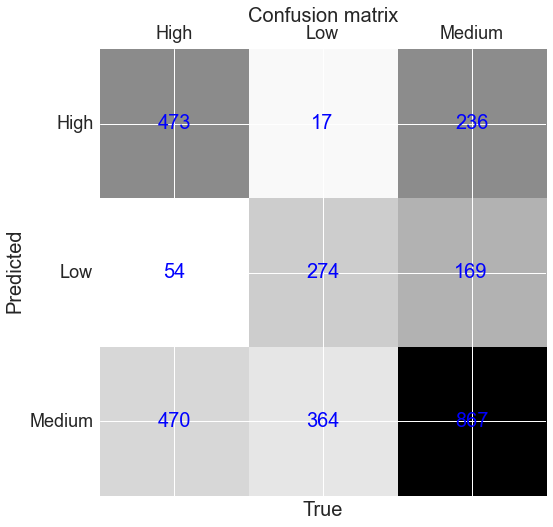

Evaluation decison tree test set:  
	
Accuracy:0.552 

Classification report
             precision    recall  f1-score   support

High [>30 eur]       0.65      0.47      0.55       997
Low [<= 10 eur]       0.55      0.42      0.48       655
Medium [>10 to 30 eur]       0.51      0.68      0.58      1272

avg / total       0.57      0.55      0.55      2924




In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

y_pred= clf_dt.predict(X_test)


def draw_confusion(y_test,y_pred,labels):
    cm = metrics.confusion_matrix(y_test,  y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=18)
    ax.set_yticklabels([''] + labels, size=18)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in xrange(3):
        for j in xrange(3):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='blue',size=20)
    fig.set_size_inches(8,8)
    plt.show()
    
    
draw_confusion(y_test, y_pred ,['High', 'Low','Medium'])

print 'Evaluation decison tree test set:  '   
print '\t'

measure_performance(X_test,y_test,clf_dt, show_accuracy=True, \
                    show_classification_report=True,show_confusion_matrix=False, show_r2_score=False)



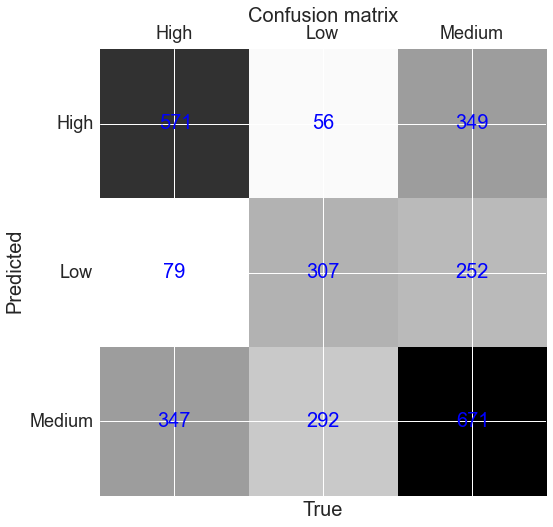

Evaluation random forest test set:  
	
Accuracy:0.530 

Classification report
             precision    recall  f1-score   support

High [>30 eur]       0.59      0.57      0.58       997
Low [<= 10 eur]       0.48      0.47      0.47       655
Medium [>10 to 30 eur]       0.51      0.53      0.52      1272

avg / total       0.53      0.53      0.53      2924




In [26]:
y_pred= clf_rf.predict(X_test)

draw_confusion(y_test, y_pred,['High', 'Low','Medium'])

print 'Evaluation random forest test set:  '   
print '\t'
       
measure_performance(X_test,y_test,clf_rf, show_accuracy=True, \
                    show_classification_report=True,show_confusion_matrix=False, show_r2_score=False)


###FEATURE SELECTION

In [27]:
feature_names= data[['zipcode','gender','age','day']]

from sklearn.feature_selection import *

fs=SelectKBest(score_func=f_classif,k=3) #Select the best 3 features

X_new_train=fs.fit_transform(X_train,np.ravel(y_train))
X_new_test=fs.fit_transform(X_test,np.ravel(y_test))

print 'Features considered: ', zip(fs.get_support(),feature_names) # Show the selected features

print '\t'

print 'Original test shape:', X_test.shape
print 'Original train shape:', X_train.shape

print '\t'

print 'New train shape:', X_new_train.shape
print 'New test shape:', X_new_test.shape

Features considered:  [(True, 'zipcode'), (False, 'gender'), (True, 'age'), (True, 'day')]
	
Original test shape: (2924, 4)
Original train shape: (1252, 4)
	
New train shape: (1252, 3)
New test shape: (2924, 3)


In [28]:
#Fitting with the best k=3 features insted of k=4

clf_fs = RandomForestClassifier()#tree.DecisionTreeClassifier()  

clf_fs = clf_fs.fit(X_new_train, np.ravel(y_train)) 

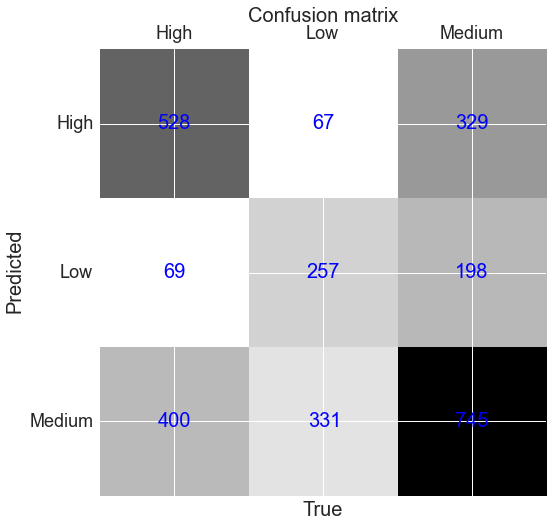

Evaluation random forest test set:  
	
Accuracy:0.523 

Classification report
             precision    recall  f1-score   support

High [>30 eur]       0.57      0.53      0.55       997
Low [<= 10 eur]       0.49      0.39      0.44       655
Medium [>10 to 30 eur]       0.50      0.59      0.54      1272

avg / total       0.52      0.52      0.52      2924




In [29]:
y_pred= clf_fs.predict(X_new_test)

draw_confusion(y_test, y_pred,['High', 'Low','Medium'])

print 'Evaluation random forest test set:  '   
print '\t'
       
measure_performance(X_new_test,y_test,clf_fs, show_accuracy=True, \
                    show_classification_report=True,show_confusion_matrix=False, show_r2_score=False)
